11 0 0
12 3 0
13 6 0
14 9 0
21 0 3
22 3 3
23 6 3
24 9 3
31 0 6
32 3 6
33 6 6
34 9 6
41 0 9
42 3 9
43 6 9
44 9 9
[0.0, 0.0]
[3.0, 0.0]
[6.0, 0.0]
[9.0, 0.0]
111 11 21 [0.0, 0.0] [0.0, 3.0]
112 12 22 [3.0, 0.0] [3.0, 3.0]
113 13 23 [6.0, 0.0] [6.0, 3.0]
114 14 24 [9.0, 0.0] [9.0, 3.0]
121 21 31 [0.0, 3.0] [0.0, 6.0]
122 22 32 [3.0, 3.0] [3.0, 6.0]
123 23 33 [6.0, 3.0] [6.0, 6.0]
124 24 34 [9.0, 3.0] [9.0, 6.0]
131 31 41 [0.0, 6.0] [0.0, 9.0]
132 32 42 [3.0, 6.0] [3.0, 9.0]
133 33 43 [6.0, 6.0] [6.0, 9.0]
134 34 44 [9.0, 6.0] [9.0, 9.0]
221 21 22 [0.0, 3.0] [3.0, 3.0]
222 22 23 [3.0, 3.0] [6.0, 3.0]
223 23 24 [6.0, 3.0] [9.0, 3.0]
231 31 32 [0.0, 6.0] [3.0, 6.0]
232 32 33 [3.0, 6.0] [6.0, 6.0]
233 33 34 [6.0, 6.0] [9.0, 6.0]
241 41 42 [0.0, 9.0] [3.0, 9.0]
242 42 43 [3.0, 9.0] [6.0, 9.0]
243 43 44 [6.0, 9.0] [9.0, 9.0]


<Axes: >

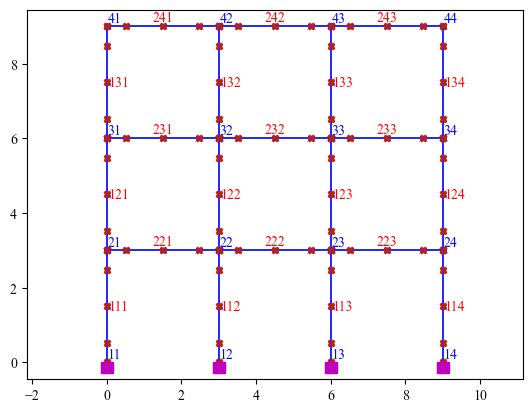

In [1]:
# import packages
# opensees packages
import openseespy.opensees as ops
import opsvis as ovs
import opstool as otl
#other packages
import numpy as np
import matplotlib.pyplot as plt

# user def modules
from modelUnits import *

# Global Variables for model
# Section tags for Elastic Beam and Column Section
ColSecTag = 1
BeamSecTag = 2

# Geometric Transformation Tags
ColSecTransf = 1
BeamSecTransf = 2


# model building function
def getModel(NBay, NStory, LBeam, LCol, sectionType = 'Elastic'):
    ops.wipe()

    ops.model('BasicBuilder', '-ndm', 2, '-ndf', 3)

    for j in range(NStory + 1):
        for i in range(NBay + 1):
            # nodeTag = j * (NBay+1) + i + 1 # conventional node tag
            nodeTag = int(f"{j+1}{i+1}") #example: nodeTag 11 means 1st node of ground floor (1st floor)
            nodeCoor = (i * LBeam, j * LCol)
            
            print(nodeTag, *nodeCoor)
            ops.node(nodeTag, *(nodeCoor))

    # fixity to the nodes
    ops.fixY(0.0, 1, 1, 1)

    # determine support nodes where ground motions are input, for multiple-support excitation
    level = 1
    iSupportNode = [int(f"{level}{i+1}") for i in range(0, NBay + 1 )]

    # Set up parameters that are particular to the model for displacement control
    IDctrlNode =  (NStory+1)*10+1		# node where displacement is read for displacement control
    IDctrlDOF =  1	                    # DoF of displacement read for displacement control
    LBuilding =  NStory*LCol	        # total building height

    # building up the elements
    if sectionType == 'Elastic':
        getElasticSection()

    for nod in iSupportNode:
        print(ops.nodeCoord(nod))


    # Building the elements
    #element('nonlinearBeamColumn', eleTag, *eleNodes, numIntgrPts, secTag, transfTag)
    numItgrPts = 5

    colNameId = 1 #elements starting with this for col
    beamNameId = 2

    for j in range(NStory):
        for i in range(NBay + 1):
            # nodeTag = j * (NBay+1) + i + 1 # conventional node tag
            eleColTag = int(f"{colNameId}{j+1}{i+1}") #example: nodeTag 11 means 1st node of ground floor (1st floor)
            inodeTag = int(f"{j+1}{i+1}")
            jnodeTag = int(f"{j+2}{i+1}")
            print(eleColTag, inodeTag, jnodeTag, ops.nodeCoord(inodeTag), ops.nodeCoord(jnodeTag))

            # element('nonlinearBeamColumn', eleTag, *eleNodes, numIntgrPts, secTag, transfTag)
            ops.element('nonlinearBeamColumn', eleColTag, *[inodeTag, jnodeTag], numItgrPts, ColSecTag, ColSecTransf)

    for j in range(1, NStory + 1): #because we dont have beam at ground level
        for i in range(NBay):
            # nodeTag = j * (NBay+1) + i + 1 # conventional node tag
            eleBeamTag = int(f"{beamNameId}{j+1}{i+1}") #example: nodeTag 11 means 1st node of ground floor (1st floor)
            inodeTag = int(f"{j+1}{i+1}")
            jnodeTag = int(f"{j+1}{i+2}")
            print(eleBeamTag, inodeTag, jnodeTag, ops.nodeCoord(inodeTag), ops.nodeCoord(jnodeTag))

            ops.element('nonlinearBeamColumn', eleBeamTag, *[inodeTag, jnodeTag], numItgrPts, BeamSecTag, BeamSecTransf)


def getElasticSection():
    # section geometry
    # column sections: W27x114
    AgCol = 33.5*sqinch	                # cross-sectional area
    IzCol = 4090.*inch4	                # moment of Inertia

    # beam sections: W24x94
    AgBeam = 27.7*sqinch		        # cross-sectional area
    IzBeam = 2700.*inch4	            # moment of Inertia

    # material properties
    Es = 29000*ksi		# Steel Young's Modulus
    nu = 0.3
    Gs = Es/2./(1+nu)  # Torsional stiffness Modulus

    ops.geomTransf('Linear', ColSecTransf)
    ops.geomTransf('Linear', BeamSecTransf)

    ops.section('Elastic', BeamSecTag, Es, AgBeam, IzBeam)
    ops.section('Elastic', ColSecTag, Es, AgCol, IzCol)

getModel(NBay=3, NStory=3, LBeam=3, LCol=3)
ovs.plot_model()